In [24]:
%load_ext autoreload
%autoreload 2

import logging
import numpy as np
from scipy.stats import ortho_group
from matplotlib import pyplot as plt
import seaborn as sns
from munch import Munch
import torch
from torch.distributions import Normal, Independent
from torch.utils.data import DataLoader
from pyro.nn import DenseNN
from pyro.distributions.transforms import AffineCoupling

from vaemcmc.models.encoders import EncoderMLP
from vaemcmc.models.decoders import DecoderMLP
from vaemcmc.vae import NormalNormalVAE, VAETarget, VAEProposal
from vaemcmc.mcmc import ISIRKernel
from vaemcmc.datasets.synthetic import SyntheticDataset
from vaemcmc.datasets.sampler import InfiniteSampler
from vaemcmc.trainer import Trainer
from vaemcmc.viz.synthetic import plot_kde, plot_chain, scatter
from vaemcmc.models.rnvp import RNVP, FlowML

from vaemcmc.distributions.synthetic import MoIG
from vaemcmc.distributions.transforms import GaussianEmbedding

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
args = Munch(
    amb_dim = 1024,
    manifold_dim = 1024,
    lat_dim = 8,
    hidden_dim = 64,
    n_blocks = 2,
    n_particles = 25,
    n_chains = 10,
    burn_in = 500,
    n_samples = 1000,
    n_epoch = 35,
    dummy_noise_scale = 1.0,
)


In [31]:
AMB_DIM = 16 #1024
LAT_DIM = 8
NUM_BLOCKS = 2
HIDDEN_DIM = 64

xlim = (-15, 15)
ylim = (-15, 15)

PROJ = (0, 1)

locs = 10 * torch.stack([torch.cos(2 * np.pi * torch.arange(9) / 9.), torch.sin(2 * np.pi * torch.arange(9) / 9.)], 1)
locs = torch.cat([locs, torch.zeros(locs.shape[0], AMB_DIM - 2)], 1)
# covs = torch.eye(AMB_DIM)[None, ...].repeat(locs.shape[0], 1, 1)
# covs[:, 2:, 2:] *= 0.1
covs = torch.ones(AMB_DIM)[None, ...].repeat(locs.shape[0], 1)
# covs[:, 2:] *= 0.1

target = MoIG(locs, covs)

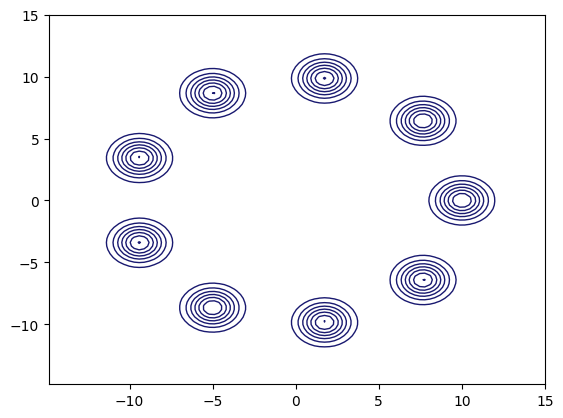

In [32]:
ax = plt.subplot()
target.plot_2d_contour(ax)

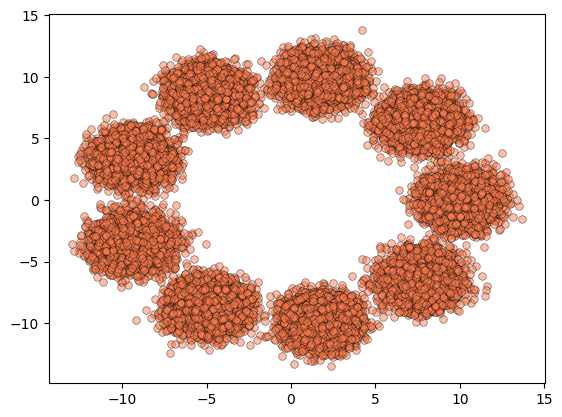

In [33]:
true_sample = target.sample((500 * 100,))
scatter(true_sample[..., PROJ].view(-1, 2));
# plt.axis('square')
# plt.show()

In [34]:

# train_dataset = TensorDataset(target.sample(1000))
train_dataset = SyntheticDataset(target.sample((10000,)))
sampler = InfiniteSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=16, sampler=sampler)

val_dataset = SyntheticDataset(target.sample((10000,)))
val_dataloader = DataLoader(val_dataset, batch_size=16)

encoder = EncoderMLP(AMB_DIM, LAT_DIM, HIDDEN_DIM)
decoder = DecoderMLP(LAT_DIM, AMB_DIM, HIDDEN_DIM)

sigma = 1.
vae = NormalNormalVAE(encoder, decoder)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

logging.basicConfig(format='%(asctime)s [%(levelname)-8s] %(message)s')
logger = logging.getLogger()
logger.setLevel(logging.INFO)
    
trainer = Trainer(vae, optimizer, train_dataloader, val_dataloader=val_dataloader, logger=logger)


In [35]:
trainer.train(5000)

100%|██████████| 5000/5000 [00:08<00:00, 579.50it/s]


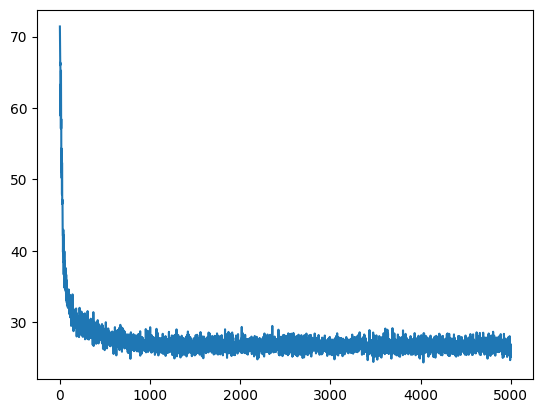

In [36]:
plt.plot(trainer.training_stats['loss'])

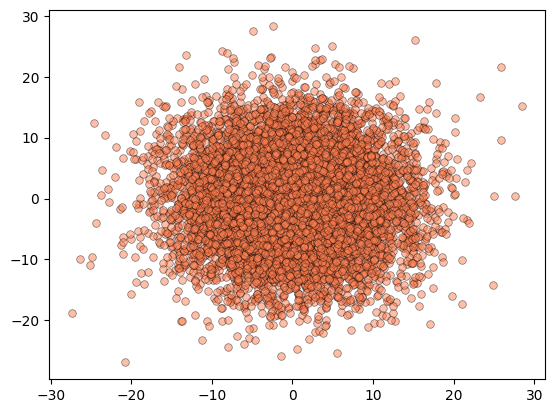

In [37]:
vae_sample = vae.sample((10000,)).detach().cpu()

scatter(vae_sample[..., PROJ]);

(-15.0, 15.0)

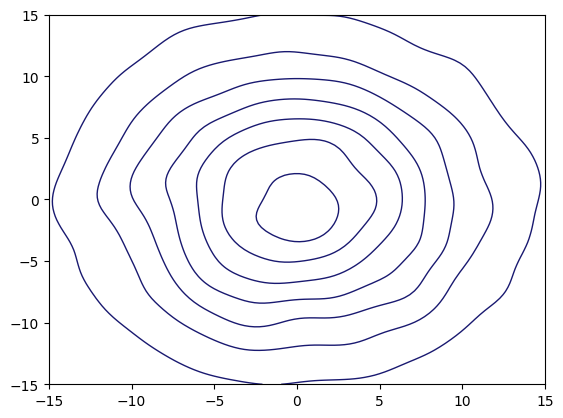

In [38]:
sample = vae.sample((20000,)).detach().cpu()
fig = plot_kde(sample[..., PROJ], xlim, ylim)
ax = fig.get_axes()[0]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_aspect('equal')

In [39]:
# z_start = vae.prior.sample((100,))


# # target_vae = VAETarget(vae, target)
# proposal = VAEProposal(vae, vae.prior)
# isir_kernel = ISIRKernel(target, proposal=proposal, n_particles=25)

In [40]:
# vae_z_chain = isir_kernel.run(z_start, 500, 500)

In [41]:
# x_start = vae.decode(z_start).detach().cpu()
# vae_x_chain = vae.decode(vae_z_chain).detach().cpu()

In [48]:
prior = Independent(Normal(torch.zeros(args.lat_dim), 0.5 ** .5 * torch.ones(args.lat_dim)), 1)
proposal = VAEProposal(vae, prior)

x_start = true_sample[np.random.choice(np.arange(true_sample.shape[0]), args.n_chains)]
# x_start = proposal.sample((args.n_chains,))

isir_kernel = ISIRKernel(target, proposal=proposal, n_particles=args.n_particles)
vae_x_chain = isir_kernel.run(x_start, args.burn_in, args.n_samples)

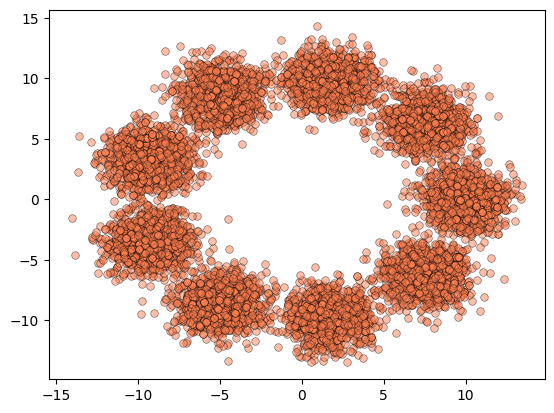

In [49]:
scatter(vae_x_chain[..., PROJ].view(-1, 2));

(-15.0, 15.0)

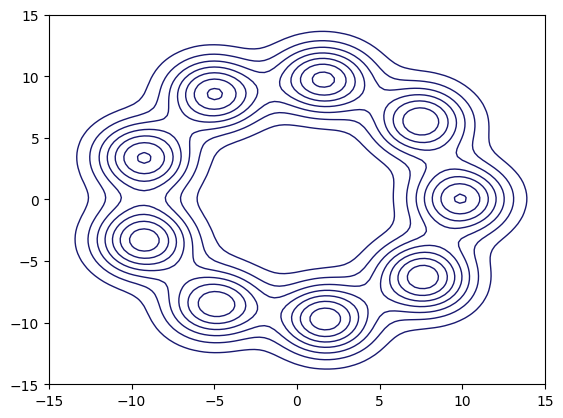

In [44]:
fig = plot_kde(vae_x_chain[..., PROJ], xlim, ylim)
ax = fig.get_axes()[0]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_aspect('equal')


(-15.0, 15.0)

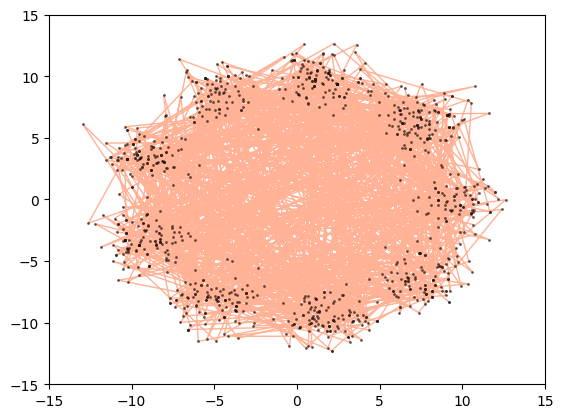

In [45]:
fig = plot_chain(vae_x_chain[:, 1, PROJ])
ax = fig.get_axes()[0]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_aspect('equal')


In [29]:
split_dim = max(AMB_DIM - HIDDEN_DIM, AMB_DIM // 2)
flows = [
    AffineCoupling(
        split_dim,
        DenseNN(
            split_dim,
            [HIDDEN_DIM],
            [AMB_DIM - split_dim, AMB_DIM - split_dim],
        ),
    )
    for _ in range(NUM_BLOCKS - 1)
]
split_dim = max(AMB_DIM - HIDDEN_DIM, AMB_DIM // 2)
flows.append(
    AffineCoupling(
        split_dim,
        DenseNN(
            split_dim,
            [HIDDEN_DIM],
            [AMB_DIM - split_dim, AMB_DIM - split_dim],
        ),
    )
)

rnvp = RNVP(flows=flows, dim=AMB_DIM)
rnvp_ml = FlowML(rnvp)
optimizer = torch.optim.Adam(rnvp_ml.parameters(), lr=3e-4)
trainer = Trainer(rnvp_ml, optimizer, train_dataloader, val_dataloader)

In [30]:
trainer.train(25)

2023-05-30 11:16:25,297 [INFO    ] 4%|4         | 1/25 [00:02<01:05,  2.72s/it]
2023-05-30 11:16:26,960 [INFO    ] Loss: 1499.2462158203125
2023-05-30 11:16:30,329 [INFO    ] 12%|#2        | 3/25 [00:07<00:56,  2.55s/it]
2023-05-30 11:16:30,934 [INFO    ] Loss: 1500.916259765625
2023-05-30 11:16:33,535 [INFO    ] 16%|#6        | 4/25 [00:10<00:58,  2.81s/it]
2023-05-30 11:16:35,964 [INFO    ] Loss: 1503.794921875
2023-05-30 11:16:39,495 [INFO    ] 24%|##4       | 6/25 [00:16<00:55,  2.90s/it]
2023-05-30 11:16:40,513 [INFO    ] Loss: 1498.71337890625
2023-05-30 11:16:42,421 [INFO    ] 28%|##8       | 7/25 [00:19<00:52,  2.91s/it]
2023-05-30 11:16:45,918 [INFO    ] Loss: 1495.1351318359375
2023-05-30 11:16:48,903 [INFO    ] 36%|###6      | 9/25 [00:26<00:48,  3.06s/it]
2023-05-30 11:16:50,524 [INFO    ] Loss: 1494.3756103515625
2023-05-30 11:16:54,150 [INFO    ] 44%|####4     | 11/25 [00:31<00:39,  2.83s/it]
2023-05-30 11:16:54,642 [INFO    ] Loss: 1497.89453125
2023-05-30 11:16:56,719 [

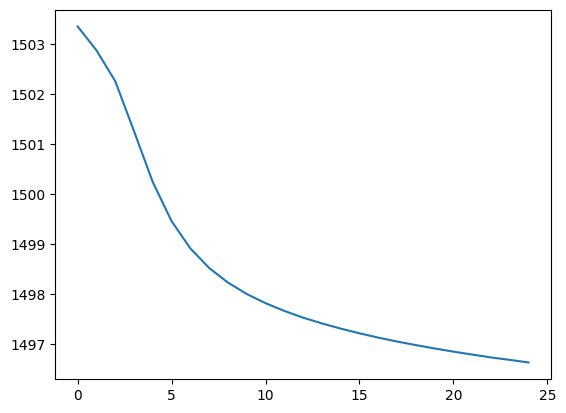

In [31]:
plt.plot(trainer.training_stats['epoch_loss'])

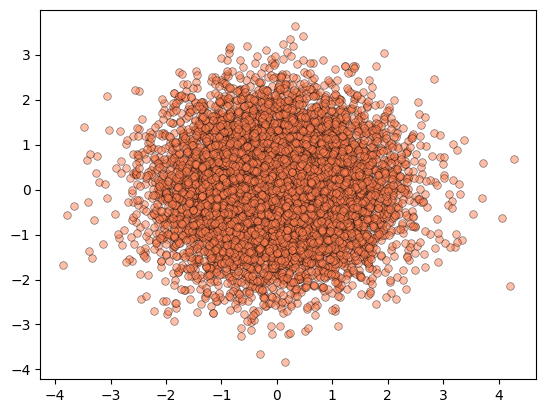

In [32]:
rnvp_sample = rnvp.sample((10000,)).detach().cpu()

scatter(rnvp_sample[:, PROJ]);

(-15.0, 15.0)

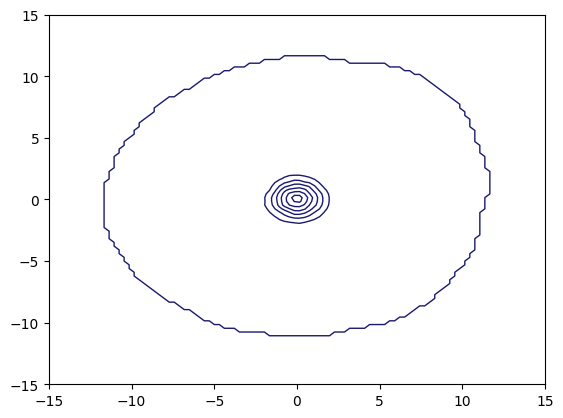

In [33]:
sample = rnvp.sample((20000,)).detach().cpu()
fig = plot_kde(sample[..., PROJ], xlim, ylim)
ax = fig.get_axes()[0]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_aspect('equal')


In [21]:
proposal = rnvp
isir_kernel = ISIRKernel(target, proposal=proposal, n_particles=25)

In [22]:
z_start = rnvp.sample((100,))
rnvp_x_chain = isir_kernel.run(z_start, 500, 500)

In [23]:
# x_start = rnvp.inverse(z_start)[0].detach().cpu()
# x_chain = rnvp.inverse(chain)[0].detach().cpu()
x_start = z_start.detach().cpu()
rnvp_x_chain = rnvp_x_chain.detach().cpu()

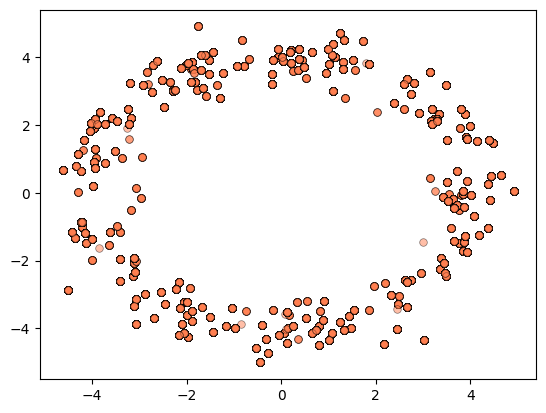

In [24]:
scatter(rnvp_x_chain[..., PROJ].view(-1, 2));


(-15.0, 15.0)

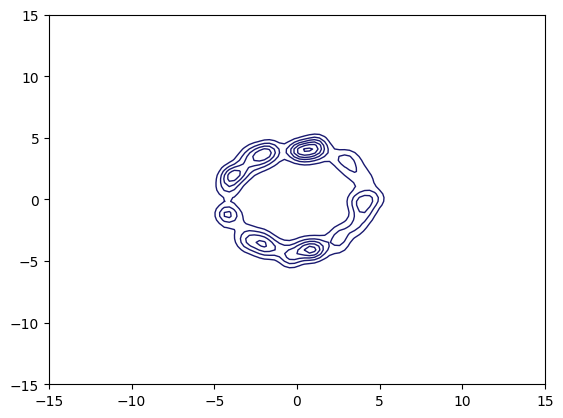

In [25]:
fig = plot_kde(rnvp_x_chain[..., PROJ], xlim, ylim)
ax = fig.get_axes()[0]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_aspect('equal')


(-15.0, 15.0)

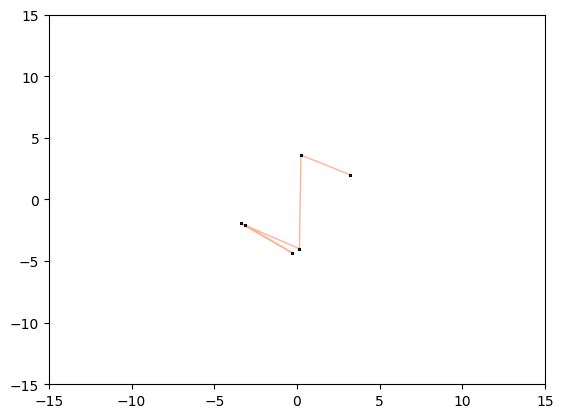

In [26]:
fig = plot_chain(rnvp_x_chain[:, 0, PROJ])
ax = fig.get_axes()[0]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_aspect('equal')


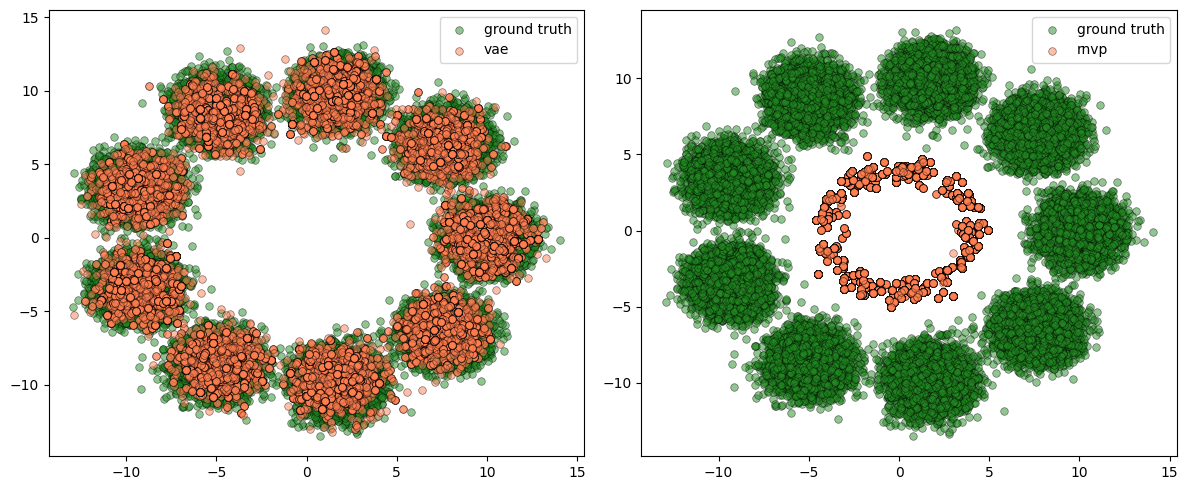

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

scatter(true_sample[..., PROJ], c='forestgreen', ax=axs[0], label='ground truth')
scatter(vae_x_chain[..., PROJ].view(-1, 2), ax=axs[0], label='vae')

scatter(true_sample[..., PROJ], c='forestgreen', ax=axs[1], label='ground truth')
scatter(rnvp_x_chain[..., PROJ].view(-1, 2), ax=axs[1], label='rnvp')

fig.tight_layout()
for ax in axs:
    ax.legend()
plt.savefig('../figs/vae_rnvp_mog.png')